In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazonreviews/test.ft.txt.bz2
/kaggle/input/amazonreviews/train.ft.txt.bz2


In [1]:
import pandas as pd
import numpy as np
import bz2
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline

In [2]:
def labels_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    return np.array(labels), texts

In [4]:
train_label, train_text = labels_texts('/Users/palas/Downloads/archive_amazon reviews/train.ft.txt.bz2')
test_label, test_text = labels_texts('/Users/palas/Downloads/archive_amazon reviews//test.ft.txt.bz2')

In [10]:
# labels_mod = []
# texts_mod = []
test_text

['Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"',
 "One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of s

In [5]:
print(train_label[0])
print(train_text[0])

1
Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^


In [16]:
import re
not_numChar = re.compile(r'[\W]')
no_encode = re.compile(r'[^a-z0-1\s]')
def normalisation(texts):
    norm_text = []
    for word in texts:
        lower = word.lower()
        not_punct = not_numChar.sub(r' ', lower)
        exclude_no_encode = no_encode.sub(r'', not_punct)
        norm_text.append(exclude_no_encode)
    return norm_text

In [17]:
train_text = normalisation(train_text)
test_text = normalisation(test_text)

In [18]:
print(train_text[0])

stuning even for the non gamer  this sound track was beautiful  it paints the senery in your mind so well i would recomend it even to people who hate vid  game music  i have played the game chrono cross but out of all of the games i have ever played it has the best music  it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras  it would impress anyone who cares to listen    


In [19]:
y_train = np.array(train_label)
y_test = np.array(test_label)

In [20]:
y_test.shape

(400000,)

In [21]:
max_features = 8192
maxlen = 128
embed_size = 64

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_text)

In [22]:
training_token = tokenizer.texts_to_sequences(train_text)
testing_token = tokenizer.texts_to_sequences(test_text)

In [23]:
x_train = pad_sequences(training_token, maxlen = maxlen, padding = 'post')
x_test = pad_sequences(testing_token, maxlen = maxlen, padding = 'post')

In [24]:
# for accessing TPU v3.8 resources in kaggle notebook
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strata = tf.distribute.experimental.TPUStrategy(tpu)

### fully connected convolutional 

Model was executed on the kaggle notebook using TPU v3.8 for faster execution.
if you are in conda environment and native jupyter notebook with higher GPU and memory recources then
execute the followling model without
**"with tpu_strata.scope():"**

In [25]:
BATCH_SIZE = 16* tpu_strata.num_replicas_in_sync
with tpu_strata.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_features, embed_size, input_length = maxlen),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64, 5, activation = 'relu'),
        tf.keras.layers.MaxPooling1D(pool_size = 4),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    model.compile('adam', 'binary_crossentropy', metrics = ['accuracy'], steps_per_execution=16)
    model.summary()

history = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = 5, validation_data = (x_train, y_train), verbose = 2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 64)           524288    
_________________________________________________________________
dropout (Dropout)            (None, 128, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 124, 64)           20544     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 31, 64)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [26]:
model.evaluate (x_test, y_test)

12500/12500 [==============================] - 36s 3ms/step - loss: 0.1523 - accuracy: 0.9428


[0.1522504985332489, 0.9428074955940247]

<Figure size 432x288 with 0 Axes>

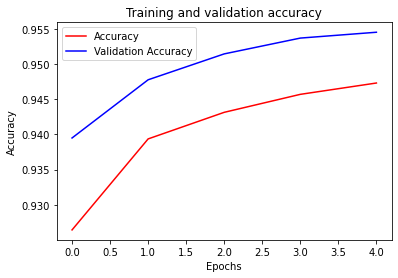

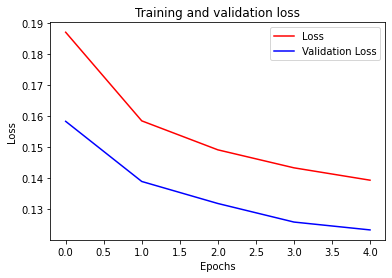

<Figure size 432x288 with 0 Axes>

In [27]:
import matplotlib.image  as mpimg

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

------------------------------------------------
### Using a bidirectional LSTM model

In [28]:
BATCH_SIZE = 16* tpu_strata.num_replicas_in_sync
with tpu_strata.scope():
    model_lstm = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_features, embed_size, input_length = maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    model_lstm.compile('adam', 'binary_crossentropy', metrics = ['accuracy'], steps_per_execution=16)
    model_lstm.summary()

history_lstm = model_lstm.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = 5, validation_data = (x_train, y_train), verbose = 2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 64)           524288    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 557,569
Trainable params: 557,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
28125/28125 - 215s - loss: 0.1682 - accuracy: 0.9352 - val_loss: 0.1413 - val_accuracy: 0.9472
Epoch 2/5
28125/28125 - 197s - loss: 0.1362 - accuracy: 0.9494 - val_loss: 0.1208 - val_accuracy: 0.9562
Epoch 3/5
28125/28125 - 197s - loss:

In [31]:
model_lstm.evaluate(x_test, y_test)

12500/12500 [==============================] - 38s 3ms/step - loss: 0.1405 - accuracy: 0.9492


[0.14047685265541077, 0.9491999745368958]

<Figure size 432x288 with 0 Axes>

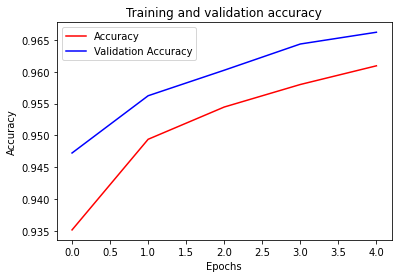

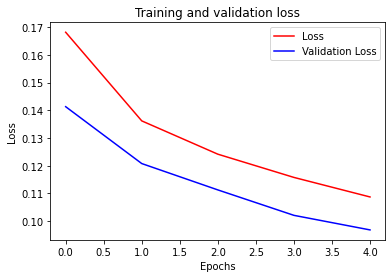

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.image  as mpimg

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history_lstm.history['accuracy']
val_acc=history_lstm.history['val_accuracy']
loss=history_lstm.history['loss']
val_loss=history_lstm.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

-------------------------------------------------------------------------------
## NLP using simple linear regression 

In [30]:
# from sklearn.feattokenizerxtraction.text import CountVectorizer
# countVector = CountVectorizer(True)
# countVector.fit(train_text)
# x = countVector.transform(train_text)
# X_test = countVector.transform(test_text)

In [2]:
#commit